<a href="https://colab.research.google.com/github/eldadHaber/EOAS555/blob/main/SEIRmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim


In [ ]:
# Open data from URL using pandas
url = 'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv' 

df = pd.read_csv(url)
 
# This is what the data looks like 
print(df)


      pruid                  prname  ... avgratedeaths_last7 raterecovered
0        35                 Ontario  ...                 NaN          0.00
1        59        British Columbia  ...                 NaN          0.00
2         1                  Canada  ...                 NaN          0.00
3        35                 Ontario  ...                 NaN          0.00
4        59        British Columbia  ...                 NaN          0.00
...     ...                     ...  ...                 ...           ...
8542     60                   Yukon  ...                0.00          0.00
8543     61   Northwest Territories  ...                0.32          0.00
8544     62                 Nunavut  ...                0.00          2.54
8545     99  Repatriated travellers  ...                 NaN           NaN
8546      1                  Canada  ...                0.10         25.15

[8547 rows x 40 columns]


In [ ]:
# Extract data for BC 
D = df["prname"]
A = df.loc[df['prname'] == "British Columbia"]
print(A.columns)


Index(['pruid', 'prname', 'prnameFR', 'date', 'update', 'numconf', 'numprob',
       'numdeaths', 'numtotal', 'numtested', 'numtests', 'numrecover',
       'percentrecover', 'ratetested', 'ratetests', 'numtoday', 'percentoday',
       'ratetotal', 'ratedeaths', 'numdeathstoday', 'percentdeath',
       'numtestedtoday', 'numteststoday', 'numrecoveredtoday', 'percentactive',
       'numactive', 'rateactive', 'numtotal_last14', 'ratetotal_last14',
       'numdeaths_last14', 'ratedeaths_last14', 'numtotal_last7',
       'ratetotal_last7', 'numdeaths_last7', 'ratedeaths_last7',
       'avgtotal_last7', 'avgincidence_last7', 'avgdeaths_last7',
       'avgratedeaths_last7', 'raterecovered'],
      dtype='object')


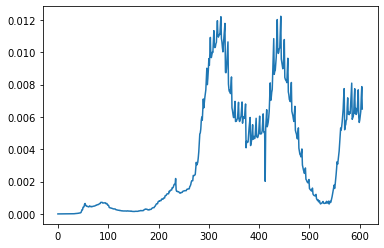

In [ ]:
# Take the date column
T = A.date
# Convert it to dtype date
T = pd.to_datetime(T)
# Make it day number
base_date = T.min()
t = T.map(lambda date : (pd.Timestamp(date) - base_date).days )

# get the number of confirmed cases per day 
Iobs = pd.to_numeric(A.numactive)

t = t.to_numpy()
Iobs = Iobs.to_numpy()
# Normalize S relative to exposed BC pop
Iobs = Iobs/1e6
# plot the number of active cases
plt.plot(t,Iobs)


In [ ]:
def SEIRmodel(S0,E0,I0,beta,gamma,mu,a,n,dt):

  SS = torch.zeros(n+1,dtype=torch.float32)
  II = torch.zeros(n+1,dtype=torch.float32)
  EE = torch.zeros(n+1,dtype=torch.float32)
  t = torch.zeros(n+1,dtype=torch.float32)
  
  beta = torch.relu(beta)
  S = S0
  I = I0
  E = E0
  SS[0] = 1.0*S
  II[0] = 1.0*I
  EE[0] = 1.0*E
  
  for i in range(1,n+1):
    # S[i+1] - S[i] = dt*(mu*N - mu*S - beta*S*I). (Assume N=1)
    # E[i+1] - E[i] = dt*beta*S*I - dt*(mu+a)*E
    # I[i+1] - I[i] = dt*a*E - dt*(mu+gamma)*I
    Sold = S
    Eold = E
    S = S - dt*beta[i-1]*S*I + dt*mu*(1.0 - S)
    E = E + dt*beta[i-1]*Sold*I - dt*(mu+a)*Eold
    I = I + dt*a*Eold - dt*(mu+gamma)*I
    t[i]  = t[i-1] + dt
    SS[i] = S
    II[i] = I
    EE[i] = E
    
  return SS, II, EE, t

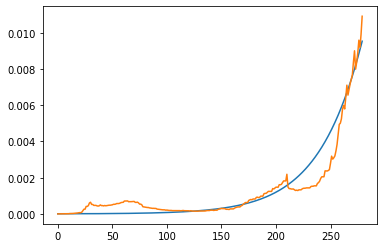

In [ ]:
S0 = 0.99998
E0 = 0.00001
I0 = 0.00001
n  = Iobs.shape[0]

beta  = 0.8*torch.ones(n,dtype=torch.float32)
gamma = 0.0015
mu    = 0.00001
a     = 0.00105
dt    = 1.0

Sc, Ic, Ec, tc = SEIRmodel(S0,E0,I0,beta,gamma,mu,a,n,dt)
plt.plot(tc[:280],Ic[:280].detach(),tc[:280],Iobs[:280])
#plt.plot(tc[:280],Ic[:280].detach())


In [ ]:
#beta  = 0.8*torch.ones(n,dtype=torch.float32)
gamma = 0.0015
mu    = 0.00001
a     = 0.00105
dt    = 1.0
numiter = 10

# Make the data torch variable
Iobs = torch.tensor(Iobs,dtype=torch.float32)
N = torch.numel(Iobs)-1
# step size (for gradient descent)
delta      = 1e-3

numiter = 10000

for i in range(numiter):
    #  compute function and its gradient
    I0 = Iobs[0]
    S0 =  1.0-I0
    
    # Make beta a parameter that we can compute gradients 
    beta = torch.tensor(beta, requires_grad=True)
    # Evaluate the objective function
    Sc, Ic, Ec, tc = SEIRmodel(S0,E0,I0,beta,gamma,mu,a,N,dt)
    # loss = torch.norm(Ic-Iobs)**2/torch.norm(Iobs)**2
    loss = F.mse_loss(Ic,Iobs)/F.mse_loss(Iobs*0,Iobs)
    
    # Compute gradients
    loss.backward()
    gradLoss = beta.grad
    # update the parameters
    with torch.no_grad():
      beta -= delta*gradLoss
      
      
    if i%100==1:
      print(i, loss.item(), torch.norm(gradLoss).item())
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1 123.66030883789062 21.43737030029297
101 82.07369995117188 19.112882614135742
201 51.19196319580078 15.873069763183594
301 31.047359466552734 12.45889949798584
401 19.043004989624023 9.47273063659668
501 12.174762725830078 7.148971080780029
601 8.235332489013672 5.450741291046143
701 5.906334400177002 4.238075256347656
801 4.469181060791016 3.3704426288604736
901 3.5413193702697754 2.740145444869995
1001 2.9162843227386475 2.2727057933807373
1101 2.4790244102478027 1.918373703956604
1201 2.1628801822662354 1.6440457105636597
1301 1.9277199506759644 1.4274799823760986
1401 1.7484803199768066 1.2534955739974976
1501 1.608945608139038 1.1115089654922485
1601 1.4983168840408325 0.9940062165260315
1701 1.4091928005218506 0.8955397605895996
1801 1.3363878726959229 0.8121152520179749
1901 1.27617347240448 0.7407258152961731
2001 1.225825309753418 0.6790889501571655
2101 1.183319330215454 0.6254490613937378
2201 1.1471149921417236 0.5784249901771545
2301 1.116037368774414 0.5369311571121216


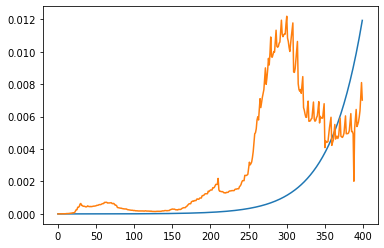

In [ ]:
plt.plot(tc[:400],Ic[:400].detach(),tc[:400],Iobs[:400])


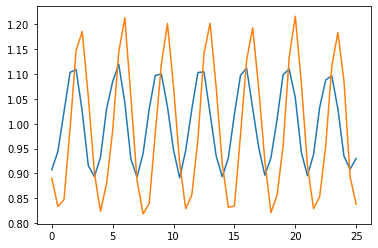

In [ ]:

def lotVol(x,y,a,b,c,d,dt,n):

  xx = torch.zeros(n+1)
  yy = torch.zeros(n+1)
  t  = torch.zeros(n+1)
  xx[0] = x; yy[0] = y
  for i in range(n):
    x = x + dt*(a*x - b*x*y)
    y = y + dt*(d*x*y - d*y)
    xx[i+1] = x
    yy[i+1] = y
    t[i+1] = t[i] + dt

  return xx, yy, t

a = 1
b = 1
c = 3
d = 3
xx,yy, t = lotVol(0.9,0.9,a,b,c,d,0.5,50)

xxn = xx + torch.randn(51)*0.01
yyn = yy + torch.randn(51)*0.01
plt.plot(t,xxn,t,yyn)

In [ ]:
t

tensor([ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
         4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
         8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
        12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
        16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
        20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
        24.0000, 24.5000, 25.0000])